# MAHTS testing

## Background


## Description

* Take full time series of NDWI in dask
* Compute 2D tides for every timestep
* Compute median of tides from entire tide timeseries
* For each year in dask NDWI timeseries:
    * Mask pixels where tide > overall median
    * `.compute()` and take median 
    
***


## Getting started


### Load packages

First we import the required Python packages, then we connect to the database, and load the catalog of virtual products.

In [356]:
%matplotlib inline

import os
import sys
import otps
import datacube
import shapely.wkt
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from skimage import measure
from skimage.morphology import disk
from skimage.morphology import square
from skimage.morphology import binary_dilation
from datacube.helpers import write_geotiff
from datacube.virtual import catalog_from_file

sys.path.append('../Scripts')
from dea_plotting import rgb
from dea_plotting import map_shapefile
from dea_plotting import display_map
from dea_spatialtools import interpolate_2d
from dea_spatialtools import contour_extract
from dea_spatialtools import largest_region


def interpolate_tide(timestep_ds, tidepoints_gdf, sigma=20):    
    '''
    Extract a subset of tide modelling point data for a given time-step,
    then interpolate these tides into the extent of the xarray dataset.
    '''
    
    # Extract subset of observations based on timestamp of imagery
    time_string = str(timestep_ds.time.values)[0:10]
    tidepoints_subset = tidepoints_gdf.loc[time_string]
    
    # Get lists of x, y and z (tide height) data to interpolate
    x_coords = tidepoints_subset.geometry.x,
    y_coords = tidepoints_subset.geometry.y,
    z_coords = tidepoints_subset.tide_m
    
    # Interpolate tides into the extent of the satellite timestep
    out_tide = interpolate_2d(ds=timestep_ds,
                              x_coords=x_coords,
                              y_coords=y_coords,
                              z_coords=z_coords,
                              fill_nearest=True,
                              sigma=sigma)
    
    # Return data as a Float32 to conserve memory
    return out_tide.astype(np.float32)


def hightide_composite(year_ds, tide_cutoff, output_dir, write_geotiff=False):
    '''
    Loads data for a time period into memory, masks to keep only
    pixels observed at > median tide, takes median and counts of valid 
    water index results, and optionally writes each water index, tide 
    height and valid pixel counts for the time period to file
    '''
    
    # Print status
    year = year_ds.time[0].dt.year.item()
    print(f'Processing {year}')
    
    # Load in data for year and mask to keep above median tide pixels
    year_ds = year_ds.compute()
    year_ds = year_ds.where(year_ds.tide_m >= tide_cutoff)
    
    # Compute median water indices and counts of valid pixels
    median_ds = year_ds.median(dim='time', keep_attrs=True)
    median_ds['count'] = (year_ds.mndwi
                          .count(dim='time', keep_attrs=True)
                          .astype('int16'))
    
    # Write each variable to file
    if write_geotiff:
        for i in median_ds:
            write_geotiff(filename=f'{output_dir}/{i}_{str(year)}.tif', 
                          dataset=median_ds[[i]])
        
    return median_ds


def mask_ocean(bool_array, **kwargs):
    '''
    Identifies ocean by selecting the largest connected area of water
    pixels, then dilating this region by 1 pixel to include mixed pixels
    '''
    
    ocean_mask = largest_region(bool_array, **kwargs)
    ocean_mask = binary_dilation(ocean_mask, 
                                 selem=square(3))

    return ocean_mask



# This will speed up loading data
import datacube.utils.rio
datacube.utils.rio.set_default_rio_config(aws='auto', cloud_defaults=True)


### Connect to the datacube

In [5]:
# dc = datacube.Datacube(app='MAHTS_testing', env='c3-samples')
dc = datacube.Datacube(app='MAHTS_testing')

### Load virtual products catalogue


In [6]:
catalog = catalog_from_file('MAHTS_virtual_products.yaml')

### Load tidal points


In [7]:
points_gdf = gpd.read_file('input_data/tide_points_coastal.geojson')

In [11]:
# Gold Coast
name = 'goldcoast'
query = {'x': (153.49, 153.5902),
         'y': (-28.1428, -28.2681),
         'time': ('2000', '2003'),
         'dask_chunks': {'time': 1},
         'cloud_cover': [0, 80]}

# # Moreton Bay
# name = 'moretonbay'
# query = {'x': (153.00, 153.25),
#          'y': (-26.81, -27.44),
#          'time': ('2008', '2008'),
#          'cloud_cover': [0, 80]}

# # Moreton Bay seam test
# name = 'moretonbay'
# query = {'x': (153.10, 153.18),
#          'y': (-26.70, -26.83),
#          'time': ('2000', '2010'),
#          'dask_chunks': {'time': 1},
#          'cloud_cover': [0, 80]}

# # Moreton Bay small
# name = 'moretonbay'
# query = {'x': (153.16, 153.2840),
#          'y': (-27.315, -27.4416),
#          'time': ('2000', '2010'),
# #          'output_crs': 'EPSG:32756',
# #          'resolution': (-30, 30),
#          'dask_chunks': {'time': 1},
#          'cloud_cover': [0, 80]}

# # Fremantle
# name = 'fremantle'
# query = {'x': (115.70,  115.81),
#          'y': (-31.94, -32.08),
#          'time': ('1987', '2018'),
#          'dask_chunks': {'time': 1},
#          'cloud_cover': [0, 80]}


# Preview study area
display_map(x=query['x'], y=query['y'])

## Load virtual product

In [24]:
# product = catalog['ls_nbart_indices']
# ds = product.load(dc, **query)
# ds

from dea_datahandling import load_ard
from dea_bandindices import calculate_indices

ds = load_ard(dc=dc, 
              measurements=['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2'], 
              min_gooddata=0.0,
              products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'], 
              output_crs='epsg:32756',
              resolution=(-30, 30),              
              **query)

ds = (calculate_indices(ds, index=['NDWI', 'MNDWI', 'AWEI_ns', 'AWEI_sh'], 
                        collection='ga_ls_3', 
                        drop=True)
      .rename({'NDWI': 'ndwi', 'MNDWI': 'mndwi', 'AWEI_ns': 'awei_ns', 'AWEI_sh': 'awei_sh'}))

Loading ga_ls5t_ard_3 data
    22 observations
    Applying pixel quality mask
Loading ga_ls7e_ard_3 data
    145 observations
    Applying pixel quality mask
Loading ga_ls8c_ard_3 data
    No data for ga_ls8c_ard_3
Combining and sorting data
Masking out invalid values
    Returning 167 observations 
Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


In [227]:
ds

<xarray.Dataset>
Dimensions:  (time: 167, x: 331, y: 465)
Coordinates:
  * y        (y) float64 6.887e+06 6.887e+06 6.887e+06 ... 6.873e+06 6.873e+06
  * x        (x) float64 5.481e+05 5.481e+05 5.481e+05 ... 5.579e+05 5.58e+05
  * time     (time) datetime64[ns] 2000-01-10T23:34:57.750992 ... 2003-12-28T23:21:14.768553
Data variables:
    ndwi     (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    mndwi    (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    awei_ns  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    awei_sh  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    tide_m   (time, y, x) float32 0.6999969 0.6999969 ... 0.15331765 0.15331765
Attributes:
    crs:      epsg:32756

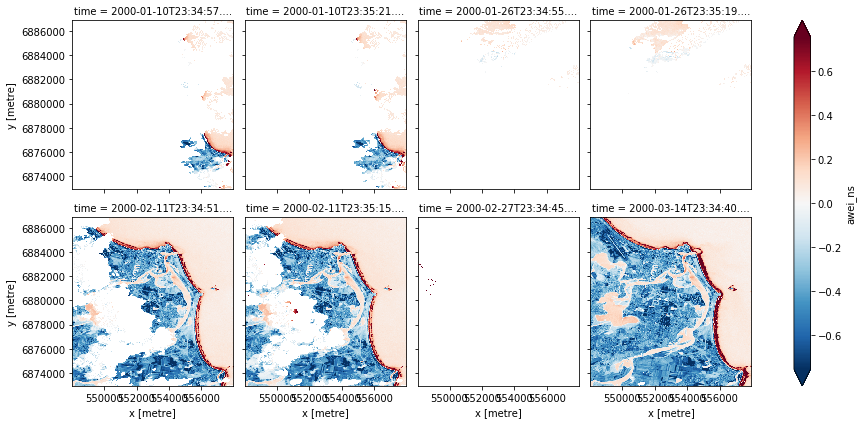

In [26]:
ds.awei_ns.isel(time=slice(0, 8)).plot.imshow(col='time', col_wrap=4, robust=True)

## Model tides

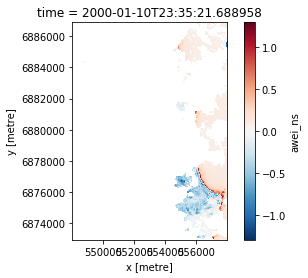

In [27]:
# Pull out subset of modelling points for region around satellite data
bounds = shapely.wkt.loads(ds.geobox.geographic_extent.buffer(0.05).wkt)
subset_gdf = points_gdf[points_gdf.geometry.intersects(bounds)]

# Extract lon, lat from tides, and time from satellite data
x_vals = subset_gdf.geometry.centroid.x
y_vals = subset_gdf.geometry.centroid.y
observed_datetimes = ds.time.data.astype('M8[s]').astype('O').tolist()

# Create list of lat/lon/time scenarios to model
observed_timepoints = [otps.TimePoint(lon, lat, date) 
                       for date in observed_datetimes
                       for lon, lat in zip(x_vals, y_vals)]

# Model tides for each scenario
observed_predictedtides = otps.predict_tide(observed_timepoints)

# Output results into pandas.DataFrame
tidepoints_df = pd.DataFrame([(i.timepoint.timestamp, 
                               i.timepoint.lon, 
                               i.timepoint.lat, 
                               i.tide_m) for i in observed_predictedtides], 
                             columns=['time', 'lon', 'lat', 'tide_m']) 

# Convert data to spatial geopandas.GeoDataFrame
tidepoints_gdf = gpd.GeoDataFrame(data={'time': tidepoints_df.time, 
                                        'i': np.unique(tidepoints_df.time, 
                                                       return_inverse=True)[1], 
                                        'tide_m': tidepoints_df.tide_m}, 
                                  geometry=gpd.points_from_xy(tidepoints_df.lon, 
                                                              tidepoints_df.lat), 
                                  crs={'init': 'EPSG:4326'})

# Reproject to satellite data CRS
tidepoints_gdf = tidepoints_gdf.to_crs(epsg=ds.crs.epsg)

# Fix time and set to index
tidepoints_gdf['time'] = pd.to_datetime(tidepoints_gdf['time'], utc=True)
tidepoints_gdf = tidepoints_gdf.set_index('time')

# Plot a sample timestep
ds.isel(time=1).awei_ns.plot()
tidepoints_gdf.plot(ax=plt.gca())

### Interpolate tides into each satellite timestep

In [28]:
# Interpolate tides for each timestep into the spatial extent of the data
tide_da = ds.groupby('time').apply(interpolate_tide, 
                                   tidepoints_gdf=tidepoints_gdf, 
                                   sigma=20)

# Determine tide cutoff
tide_cutoff = tide_da.median(dim='time')

# Add interpolated tides as measurement in satellite dataset
ds['tide_m'] = tide_da

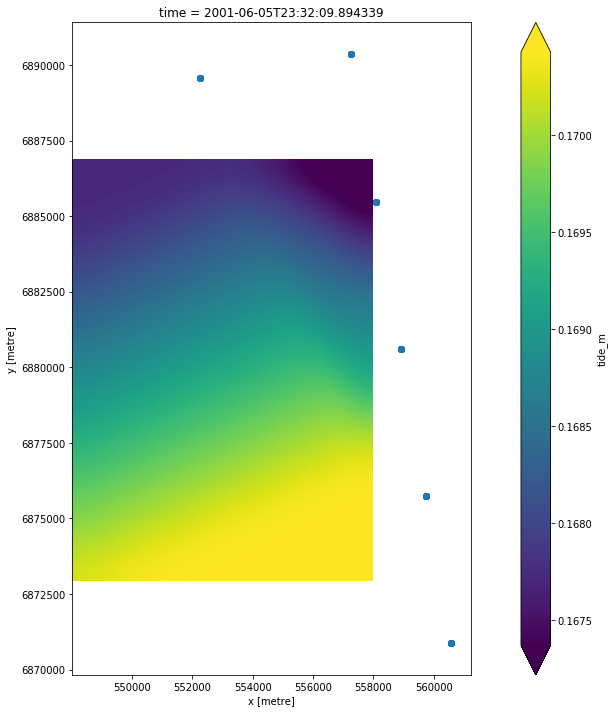

In [29]:
# Plot 
ds['tide_m'].isel(time=58).plot.imshow(robust=True, cmap='viridis', size=12)
tidepoints_gdf.plot(ax=plt.gca())

## Generate yearly composites

In [30]:
# If output folder doesn't exist, create it
output_dir = f'output_data/{name}'
os.makedirs(output_dir, exist_ok=True)

# Generate yearly high tide median water indices
yearly_ds = ds.groupby('time.year').apply(hightide_composite, 
                                          tide_cutoff=tide_cutoff, 
                                          output_dir=output_dir,
                                          write_geotiff=True)


Processing 2000
Processing 2001
Processing 2002
Processing 2003


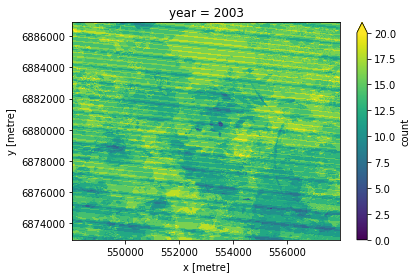

In [31]:
# Plot
yearly_ds['count'].isel(year=-1).plot(vmin=0, vmax=20)

## Extract shoreline contours

In [399]:
water_index = 'mndwi'
index_threshold = 0.0

# Apply index and threshold
thresholded_ds = yearly_ds[water_index] > index_threshold

# Drop empty timesteps
thresholded_ds = (thresholded_ds
                  .sel(year=thresholded_ds.sum(dim=['x', 'y']) > 0))

# Generate all time 600 m buffer from ocean
full_sea_mask = mask_ocean(thresholded_ds.median(dim='year'))
buffer_ocean = binary_dilation(full_sea_mask, disk(20))
buffer_land = binary_dilation(~full_sea_mask, disk(20))
sea_buffer = buffer_ocean & buffer_land

# Generate sea mask for each timestep
yearly_sea_mask = (thresholded_ds
                   .groupby('year')
                   .apply(mask_ocean))

# Keep only pixels that are within 600 m of the ocean in the
# full stack, and directly connected to ocean in each yearly timestep
masked_ds = yearly_ds[water_index]  #.where(yearly_sea_mask & sea_buffer)

# Prepare attributes as input to contour extract
attribute_data = {'year': thresholded_ds.year.values.tolist()}  
attribute_dtypes = {'year': 'str'}

In [397]:
# Extract contours with custom attribute fields:
# 42.2 ms ± 47.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
output_path = f'{output_dir}/contours_{water_index}_{index_threshold:.2f}'
contours_gdf = contour_extract(z_values=[index_threshold],
                               ds_array=masked_ds,
                               ds_crs=f'EPSG:{ds.crs.epsg}',
                               ds_affine=ds.geobox.transform,
                               output_shp=f'{output_path}.shp',
                               attribute_data=attribute_data,
                               attribute_dtypes=attribute_dtypes,
                               min_vertices=2,                                 
                               verbose=False,                                   
                               dim='year')

Operating in single z-value, multiple arrays mode


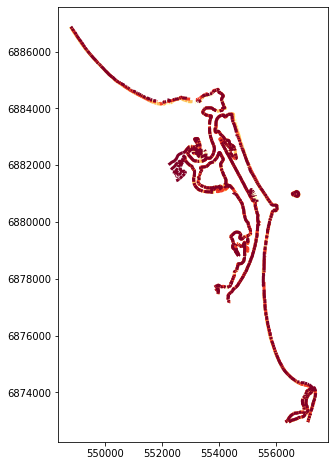

In [398]:
# Export geojson
contours_gdf.to_crs(epsg=4326).to_file(filename=f'{output_path}.geojson', 
                                       driver='GeoJSON')

# Plot
contours_gdf.plot(column='year', figsize=(12, 8), cmap='YlOrRd', linewidth=3)
# plt.gca().set_xlim(547500, 565500) 
# plt.gca().set_ylim(-3125000, -3109000)

In [401]:
# Import required packages
import fiona
import affine
import collections
import numpy as np
import xarray as xr
import geopandas as gpd
import scipy.interpolate
from scipy import ndimage as nd
from skimage.measure import label
from skimage.measure import find_contours
from shapely.geometry import MultiLineString, mapping

z_values=[index_threshold]
ds_array=masked_ds
ds_crs=f'EPSG:{ds.crs.epsg}'
ds_affine=ds.geobox.transform
output_shp=f'{output_path}.shp'
attribute_data=attribute_data,
attribute_dtypes=attribute_dtypes
min_vertices=2                                
verbose=False                                  
dim='year'


def contour_extract(ds_array,
                    z_values,
                    ds_crs,
                    ds_affine,
                    output_shp,
                    min_vertices=2,
                    attribute_data=None,
                    attribute_dtypes=None,
                    dim='time',
                    verbose=True):
    """
    Uses `skimage.measure.find_contours` to extract multiple z-value 
    contour lines from a two-dimensional array (e.g. multiple elevations
    from a single DEM), or one z-value for each array along a specified 
    dimension of a multi-dimensional array (e.g. to map waterlines 
    across time by extracting a 0 NDVI contour from each individual 
    timestep in an xarray timeseries).    
    
    Contours are exported to file as a shapefile and returned as a 
    geopandas geodataframe with one row per z-value or one row per 
    array along a specified dimension. The `attribute_data` and 
    `attribute_dtypes` parameters can be used to pass custom attributes 
    to the output contour features.
    
    Last modified: October 2019
    
    Parameters
    ----------  
    ds_array : xarray DataArray
        A two-dimensional or multi-dimensional array from which 
        contours are extracted. If a two-dimensional array is provided, 
        the analysis will run in 'single array, multiple z-values' mode 
        which allows you to specify multiple `z_values` to be extracted.
        If a multi-dimensional array is provided, the analysis will run 
        in 'single z-value, multiple arrays' mode allowing you to 
        extract contours for each array along the dimension specified 
        by the `dim` parameter.  
    z_values : int, float or list of ints, floats
        An individual z-value or list of multiple z-values to extract 
        from the array. If operating in 'single z-value, multiple 
        arrays' mode specify only a single z-value.
    ds_crs : string or CRS object
        Either a EPSG string giving the coordinate system of the array 
        (e.g. 'EPSG:3577'), or a crs object (e.g. from an xarray 
        dataset: `xarray_ds.geobox.crs`).
    ds_affine : affine.Affine object or GDAL geotransform
        Either an affine object from a rasterio or xarray object 
        (e.g. `xarray_ds.geobox.affine`), or a gdal-derived  
        geotransform object (e.g. `gdal_ds.GetGeoTransform()`) which 
        will be converted to an affine.
    output_shp : string
        The path and filename for the output shapefile.
    min_vertices : int, optional
        The minimum number of vertices required for a contour to be 
        extracted. The default (and minimum) value is 2, which is the 
        smallest number required to produce a contour line (i.e. a start
        and end point). Higher values remove smaller contours, 
        potentially removing noise from the output dataset.
    attribute_data : dict of lists, optional
        An optional dictionary of lists used to define custom 
        attributes/fields to add to the shapefile. Dict keys give the 
        name of the shapefile field, while dict values must be lists of 
        the same length as `z_values` (for 'single array, multiple 
        z-values' mode) or the number of arrays along the dimension 
        specified by the `dim` parameter (for 'single z-value, multiple 
        arrays' mode). For example, if `z_values=[0, 10, 20]`, then 
        `attribute_data={'type: [1, 2, 3]}` can be used to create a 
        shapefile field called 'type' with a value for each contour in 
        the shapefile. The default is None, which produces a default 
        shapefile field called 'z_value' with values taken directly from
        the `z_values` parameter and formatted as a 'float:9.2' ('single
        array, multiple z-values' mode), or a field named after `dim` 
        numbered from 0 to the total number of arrays along the `dim` 
        dimension ('single z-value, multiple arrays' mode).
    attribute_dtypes : dict, optional
        An optional dictionary giving the output dtype for each custom 
        shapefile attribute field specified by `attribute_data`. For 
        example, `attribute_dtypes={'type: 'int'}` can be used to set 
        the 'type' field to an integer dtype. The dictionary should have
        the same keys/field names as declared in `attribute_data`. Valid
        values include 'int', 'str', 'datetime, and 'float:X.Y', where X
        is the minimum number of characters before the decimal place, 
        and Y is the number of characters after the decimal place.
    dim : string, optional
        The name of the dimension along which to extract contours when 
        operating in 'single z-value, multiple arrays' mode. The default
        is 'time', which extracts contours for each array along the time
        dimension.
    verbose: bool, optional
        Whether to print the result of each contour extraction to the 
        console. The default is True which prints all results; set to 
        False for a cleaner output, particularly when extracting large 
        numbers of contours.
    Returns
    -------
    output_gdf : geopandas geodataframe
        A geopandas geodataframe object with one feature per z-value 
        ('single array, multiple z-values' mode), or one row per array 
        along the dimension specified by the `dim` parameter ('single 
        z-value, multiple arrays' mode). If `attribute_data` and 
        `attribute_dtypes` are provided, these values will be included 
        in the shapefile's attribute table.
        
    """

    # Obtain affine object from either rasterio/xarray affine or a 
    # gdal geotransform:
    if type(ds_affine) != affine.Affine:
        ds_affine = affine.Affine.from_gdal(*ds_affine)

    # If z_values is supplied is not a list, convert to list:
    z_values = z_values if isinstance(z_values, list) else [z_values]

    # If array has only one layer along the `dim` dimension (e.g. time), 
    # remove the dim:
    try:
        ds_array = ds_array.squeeze(dim=dim)
        print(f"Dimension '{dim}' has length of 1; removing from array")

    except:
        pass

    ########################################
    # Single array, multiple z-values mode #
    ########################################

    # Output dict to hold contours for each offset
    contours_dict = collections.OrderedDict()

    # If array has only two dimensions, run in single array, 
    # multiple z-values mode:
    if len(ds_array.shape) == 2:

        if verbose: print(f'Operating in single array, multiple z-values mode')

        # If no custom attributes given, default to including a single 
        # z-value field based on `z_values`
        if not attribute_data:

            # Default field uses two decimal points by default
            attribute_data = {'z_value': z_values}
            attribute_dtypes = {'z_value': 'float:9.2'}

        # If custom attributes are provided, test that they are equal 
        # in length to the number of `z-values`:
        else:

            for key, values in attribute_data.items():

                if len(values) != len(z_values):

                    raise Exception(
                        f"Supplied attribute '{key}' has length of {len(values)} while z_values has "
                        f"length of {len(z_values)}; please supply the same number of attribute values "
                        "as z_values")

        for z_value in z_values:

            # Extract contours and convert output array cell coords 
            # into arrays of coordinate reference system coords.
            # We need to add (0.5 x the pixel size) to the x and y 
            # values to correct coordinates to give the centre
            # point of pixels, rather than the top-left corner
            if verbose: print(f'    Extracting contour {z_value}')
            ps_x = ds_affine[0]  # Compute pixel x size
            ps_y = ds_affine[4]  # Compute pixel y size
            contours_geo = [
                np.column_stack(ds_affine * (i[:, 1], i[:, 0])) +
                np.array([0.5 * ps_x, 0.5 * ps_y])
                for i in find_contours(ds_array, z_value)
            ]

            # For each array of coordinates, drop xy points that have NA
            contours_nona = [i[~np.isnan(i).any(axis=1)] for i in contours_geo]

            # Drop 0 length and add list of contour arrays to dict
            contours_withdata = [i for i in contours_nona 
                                 if len(i) >= min_vertices]

            # If there is data for the contour, add to dict:
            if len(contours_withdata) > 0:
                contours_dict[z_value] = contours_withdata

            else:
                if verbose:
                    print(f'    No data for contour {z_value}; skipping')
                contours_dict[z_value] = None

                
    ########################################
    # Single z-value, multiple arrays mode #
    ########################################

    # For inputs with more than two dimensions, run in single z-value, 
    # multiple arrays mode:
    else:

        # Test if only a single z-value is given when operating in 
        # single z-value, multiple arrays mode
        print(f'Operating in single z-value, multiple arrays mode')
        if len(z_values) > 1:
            raise Exception('Please provide a single z-value when operating '
                            'in single z-value, multiple arrays mode')

        # If no custom attributes given, default to including one field 
        # based on the `dim` dimension:
        if not attribute_data:

            # Default field is numbered from 0 to the number of arrays 
            # along the `dim` dimension:
            attribute_data = {dim: range(0, len(ds_array[dim]))}
            attribute_dtypes = {dim: 'int'}

        # If custom attributes are provided, test that they are equal 
        # in length to the number of arrays along `dim`:
        else:

            for key, values in attribute_data.items():

                if len(values) != len(ds_array[dim]):

                    raise Exception(
                        f"Supplied attribute '{key}' has length of {len(values)} while there are "
                        f"{len(ds_array[dim])} arrays along the '{dim}' dimension. Please supply "
                        f"the same number of attribute values as arrays along the '{dim}' dimension"
                    )

        for z_value, _ in enumerate(ds_array[dim]):

            # Extract contours and convert output array cell coords into 
            # arrays of coordinate reference system coords. We need to 
            # add (0.5 x the pixel size) to the x and y values to 
            # correct coordinates to give the centre point of pixels, 
            # rather than the top-left corner
            if verbose: print(f'    Extracting contour {z_value}')
            ps_x = ds_affine[0]  # Compute pixel x size
            ps_y = ds_affine[4]  # Compute pixel y size
            contours_geo = [
                np.column_stack(ds_affine * (i[:, 1], i[:, 0])) +
                np.array([0.5 * ps_x, 0.5 * ps_y]) for i in find_contours(
                    ds_array.isel({dim: z_value}), z_values[0])
            ]

            # For each array of coordinates, drop any xy points that have NA
            contours_nona = [i[~np.isnan(i).any(axis=1)] for i in contours_geo]

            # Drop 0 length and add list of contour arrays to dict
            contours_withdata = [
                i for i in contours_nona if len(i) >= min_vertices
            ]

            # If there is data for the contour, add to dict:
            if len(contours_withdata) > 0:
                contours_dict[z_value] = contours_withdata

            else:
                if verbose:
                    print(f'    No data for contour {z_value}; skipping')
                contours_dict[z_value] = None

    #######################
    # Export to shapefile #
    #######################

    # If a shapefile path is given, generate shapefile
    if output_shp:

        if verbose: print(f'Exporting contour shapefile to {output_shp}')

        # Set up output multiline shapefile properties
        schema = {'geometry': 'MultiLineString', 
                  'properties': attribute_dtypes}

        # Create output shapefile for writing
        with fiona.open(output_shp,
                        'w',
                        crs={
                            'init': str(ds_crs),
                            'no_defs': True
                        },
                        driver='ESRI Shapefile',
                        schema=schema) as output:

            # Write each shapefile to the dataset one by one
            for i, (z_value, contours) in enumerate(contours_dict.items()):

                if contours:

                    # Create multi-string object from all contour coordinates
                    contour_multilinestring = MultiLineString(contours)

                    # Get attribute values for writing
                    attribute_vals = {field_name: field_vals[i] 
                                      for field_name, field_vals 
                                      in attribute_data.items()}

                    # Write output shapefile to file with z-value field
                    output.write({
                        'properties': attribute_vals,
                        'geometry': mapping(contour_multilinestring)
                    })

    # Return dict of contour arrays
    output_gdf = gpd.read_file(output_shp)
    return output_gdf


In [377]:
from shapely.geometry import LineString, MultiLineString

def contours_to_multiline(da, z_value=0):

    # Extract contour points as arrays and convert to Shapely LineStrings
    line_features = [LineString(gpd.points_from_xy(y=i[:,0], x=i[:,1])) 
                     for i in find_contours(da, z_value)]
    
    # Output resulting lines into a single combined MultiLineString
    return MultiLineString(line_features)



In [370]:
ds_affine.a / 2.0

15.0

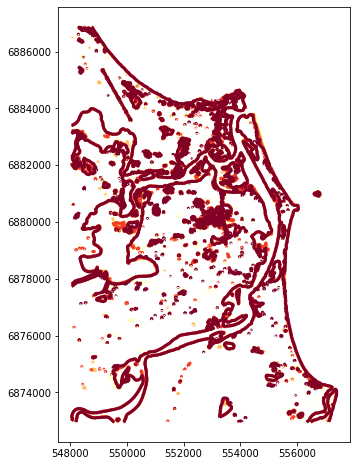

In [402]:
contour_arrays = {i: contours_to_multiline(da, 0) 
                  for i, da in ds_array.groupby(dim)}

# Convert output contours to a geopandas.GeoDataFrame
contours_gdf = gpd.GeoDataFrame(data=list(contour_arrays.keys()),
                                geometry=list(contour_arrays.values()),
                                crs={'init': str(ds.crs)})   

# Define affine and use to convert array coords to geographic coords.
# We need to add 0.5 x pixel size to the x and y to obtain the centre 
# point of our pixels, rather than the top-left corner
shapely_affine = [ds_affine.a, ds_affine.b, ds_affine.d, ds_affine.e, 
                  ds_affine.xoff + ds_affine.a / 2.0, 
                  ds_affine.yoff + ds_affine.e / 2.0]
contours_gdf['geometry'] = contours_gdf.affine_transform(shapely_affine)

# Rename the data column to match the dimension
contours_gdf = contours_gdf.rename({0: dim}, axis=1)  #.set_index(dim)

# Drop empty timesteps
contours_gdf = contours_gdf[~contours_gdf.geometry.is_empty]

# Plot
contours_gdf.plot(column=dim, cmap='YlOrRd', figsize=(12, 8), linewidth=3)

,year,geometry
1,2001,"MULTILINESTRING ((550605.000 6885163.269, 5506..."


In [374]:
ds_affine.xoff + ds_affine.a / 2.0

548040.0

In [395]:
contours_gdf.to_crs({'init': 'EPSG:4326'}).to_file(filename=f'{output_path}4.geojson', driver='GeoJSON')

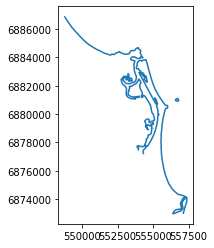

In [160]:


# ds_affine.to_gdal()
# [a, b, d, e, xoff, yoff]


# [ds_affine.a, ds_affine.b, ds_affine.d, ds_affine.e, 0.5, 0.5]

# ds_affine.to_gdal()


# a = width of a pixel
# b = row rotation (typically zero)
# c = x-coordinate of the upper-left corner of the upper-left pixel
# d = column rotation (typically zero)
# e = height of a pixel (typically negative)
# f = y-coordinate of the of the upper-left corner of the upper-left pixel

(548040.0, 30.0, 0.0, 6886890.0, 0.0, -30.0)

In [154]:
ds_affine.e

-30.0

In [144]:
ds_affine.a

30.0

In [127]:
contour_arrays

contours_geo = [i for i
                in contour_arrays]

contours_geo 

[0]

In [82]:
test2 = ds_array.isel(year=0).drop('year')
test2 = test2.expand_dims('time')

In [80]:
test

<function __main__.test(i, da, z_value=0)>

In [14]:
# map_shapefile(gdf=contours_gdf, hover_col='year')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** October 2019

**Compatible datacube version:** 

In [15]:
print(datacube.__version__)

1.7+128.gebdc898a.dirty


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)